In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27 # figure size in inches

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 30) 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config Completer.use_jedi = False

import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


from IPython.display import display

In [49]:
df_temporal_cat = pd.read_csv('CSV/df_temporal_cat.csv')

X = df_temporal_cat.iloc[:,1:-1]
y = df_temporal_cat['Stage_Progress']

X_train_temporal, X_test_temporal, y_train_temporal, y_test_temporal = train_test_split(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [54]:
df_temporal_cat_drug = pd.read_csv('CSV/df_temporal_cat_drug.csv')

X = df_temporal_cat_drug.iloc[:,1:]
X.drop('Stage_Progress', axis=1, inplace=True)
y = df_temporal_cat_drug['Stage_Progress']

X_train_temporal_drug, X_test_temporal_drug, y_train_temporal_drug, y_test_temporal_drug = train_test_split(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [38]:
# For ensemble
def get_predictions(model, preds, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds

# Build models
## Generate result and store in dict
* Set weight to prevent bias, 4 to CKD (1), 1 to non-CKD (0)
* Implement GridSearchCV to find the best parameters

In [39]:
def train_model(model, parameters, algoname, X_train, X_test, y_train, preds, months_name):

    print('========================================')
    print('Training %s ' % algoname)
    print()
    
    scores = ['f1']
    
    # retain for loop in case want to try different scores
    for score in scores:

        print("# Tuning hyper-parameters for %s" % score)
        print()

        pipe = Pipeline(steps=[('model', model)])

        search = GridSearchCV(pipe, parameters, n_jobs=-1)
        search.fit(X_train, y_train)
        
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters set found on development set:")
        print()
        print(search.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
       
        # Obtained best model
        optimized_model = search.best_estimator_
        
        # Save model
        if 'drug' in months_name:
            months_name = months_name.split('_')[0]
            joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'_cat_drug.joblib')
        else:
            joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'_cat.joblib')
        
        
        # Get predictions
        y_pred = optimized_model.predict(X_test)
        y_pred_proba = optimized_model.predict_proba(X_test)[:,1] # only get probability for 1
        
        preds[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }        
        
        return preds

In [56]:
# Logistic regression
model_lr = LogisticRegression(random_state=0, max_iter=10000, class_weight={0: 1, 1: 4})
parameters_lr = {'model__C': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100,1000, 1e4, 1e5, 1e6]}

# Decision tree
model_dt = DecisionTreeClassifier(random_state=0, class_weight={0: 1, 1: 4}, min_samples_leaf = 30)    
parameters_dt = {'model__max_depth': np.linspace(10, 100, 10)}

# lightGBM
model_lgbm = LGBMClassifier(n_estimators=1000, objective='binary',scale_pos_weight=4)
parameters_lgbm = {'model__learning_rate': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]}

# Random forest
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=800, n_jobs=-1, verbose=1)
parameters_rf = {'model__max_depth': list(range(1,31))}

In [57]:
preds_temporal = {'y': y_test_temporal}

preds_temporal = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')

joblib.dump(preds_temporal, 'predictions/predictions_temporal_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.548):

Best parameters set found on development set:

{'model__C': 100}

Grid scores on development set:

0.343 (+/-0.023) for {'model__C': 1e-05}
0.343 (+/-0.023) for {'model__C': 0.0001}
0.343 (+/-0.023) for {'model__C': 0.001}
0.343 (+/-0.023) for {'model__C': 0.01}
0.519 (+/-0.194) for {'model__C': 0.1}
0.529 (+/-0.106) for {'model__C': 1}
0.533 (+/-0.038) for {'model__C': 10}
0.548 (+/-0.043) for {'model__C': 100}
0.538 (+/-0.038) for {'model__C': 1000}
0.533 (+/-0.049) for {'model__C': 10000.0}
0.529 (+/-0.036) for {'model__C': 100000.0}
0.519 (+/-0.036) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.357):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.357 (+/-0.060) for {'model__max_depth': 10.0}
0.357 (+/-0.060) for {'model__max_depth': 20.0}
0.357 (+

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.667):

Best parameters set found on development set:

{'model__max_depth': 24}

Grid scores on development set:

0.343 (+/-0.023) for {'model__max_depth': 1}
0.343 (+/-0.023) for {'model__max_depth': 2}
0.367 (+/-0.057) for {'model__max_depth': 3}
0.438 (+/-0.137) for {'model__max_depth': 4}
0.490 (+/-0.169) for {'model__max_depth': 5}
0.524 (+/-0.197) for {'model__max_depth': 6}
0.548 (+/-0.151) for {'model__max_depth': 7}
0.581 (+/-0.103) for {'model__max_depth': 8}
0.605 (+/-0.119) for {'model__max_depth': 9}
0.657 (+/-0.088) for {'model__max_depth': 10}
0.643 (+/-0.080) for {'model__max_depth': 11}
0.633 (+/-0.038) for {'model__max_depth': 12}
0.657 (+/-0.049) for {'model__max_depth': 13}
0.657 (+/-0.071) for {'model__max_depth': 14}
0.652 (+/-0.038) for {'model__max_depth': 15}
0.652 (+/-0.023) for {'model__max_depth': 16}
0.657 (+/-0.049) for {'model__max_depth': 17}
0.662 (+/-0.036) for {'model__max_depth': 18}
0.648 (+/-0.056) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_temporal_cat.joblib']

In [58]:
folder_name = 'temporal'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_temporal, y_train_temporal)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)

# Get predictions
preds_temporal_ensemble = {'y': y_test_temporal}
preds_temporal_ensemble = get_predictions(eclf, preds_temporal_ensemble, X_test_temporal, 'VotingClassifier')
preds_temporal_ensemble = get_predictions(model_stack1, preds_temporal_ensemble, X_test_temporal, 'StackingClassifier_logistic')
preds_temporal_ensemble = get_predictions(model_stack2, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_rf')
preds_temporal_ensemble = get_predictions(model_stack3, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_lgbm')

joblib.dump(preds_temporal_ensemble, 'predictions/preds_temporal_ensemble_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_temporal_ensemble_cat.joblib']

In [59]:
preds_temporal_drug = {'y': y_test_temporal_drug}

preds_temporal_drug = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_temporal_drug, X_test_temporal_drug, y_train_temporal_drug, preds_temporal_drug, 'temporal_drug')
preds_temporal_drug = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_temporal_drug, X_test_temporal_drug, y_train_temporal_drug, preds_temporal_drug, 'temporal_drug')
preds_temporal_drug = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_temporal_drug, X_test_temporal_drug, y_train_temporal_drug, preds_temporal_drug, 'temporal_drug')
preds_temporal_drug = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_temporal_drug, X_test_temporal_drug, y_train_temporal_drug, preds_temporal_drug, 'temporal_drug')

joblib.dump(preds_temporal_drug, 'predictions/predictions_temporal_cat_drug.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.529):

Best parameters set found on development set:

{'model__C': 1}

Grid scores on development set:

0.343 (+/-0.023) for {'model__C': 1e-05}
0.343 (+/-0.023) for {'model__C': 0.0001}
0.343 (+/-0.023) for {'model__C': 0.001}
0.352 (+/-0.036) for {'model__C': 0.01}
0.481 (+/-0.152) for {'model__C': 0.1}
0.529 (+/-0.179) for {'model__C': 1}
0.519 (+/-0.155) for {'model__C': 10}
0.519 (+/-0.160) for {'model__C': 100}
0.519 (+/-0.160) for {'model__C': 1000}
0.519 (+/-0.160) for {'model__C': 10000.0}
0.519 (+/-0.160) for {'model__C': 100000.0}
0.519 (+/-0.160) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.433):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.433 (+/-0.203) for {'model__max_depth': 10.0}
0.433 (+/-0.203) for {'model__max_depth': 20.0}
0.433 (+/-

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.667):

Best parameters set found on development set:

{'model__max_depth': 21}

Grid scores on development set:

0.343 (+/-0.023) for {'model__max_depth': 1}
0.352 (+/-0.036) for {'model__max_depth': 2}
0.424 (+/-0.136) for {'model__max_depth': 3}
0.495 (+/-0.139) for {'model__max_depth': 4}
0.552 (+/-0.106) for {'model__max_depth': 5}
0.571 (+/-0.124) for {'model__max_depth': 6}
0.567 (+/-0.163) for {'model__max_depth': 7}
0.614 (+/-0.110) for {'model__max_depth': 8}
0.643 (+/-0.080) for {'model__max_depth': 9}
0.648 (+/-0.036) for {'model__max_depth': 10}
0.638 (+/-0.063) for {'model__max_depth': 11}
0.643 (+/-0.060) for {'model__max_depth': 12}
0.643 (+/-0.052) for {'model__max_depth': 13}
0.643 (+/-0.052) for {'model__max_depth': 14}
0.643 (+/-0.052) for {'model__max_depth': 15}
0.648 (+/-0.063) for {'model__max_depth': 16}
0.648 (+/-0.087) for {'model__max_depth': 17}
0.652 (+/-0.057) for {'model__max_depth': 18}
0.648 (+/-0.063) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_temporal_cat_drug.joblib']

In [60]:
folder_name = 'temporal'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_cat_drug.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_cat_drug.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_cat_drug.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_cat_drug.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_temporal_drug, y_train_temporal_drug)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_temporal_drug, y_train_temporal_drug)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_temporal_drug, y_train_temporal_drug)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_temporal_drug, y_train_temporal_drug)

# Get predictions
preds_temporal_drug_ensemble = {'y': y_test_temporal_drug}
preds_temporal_drug_ensemble = get_predictions(eclf, preds_temporal_drug_ensemble, X_test_temporal_drug, 'VotingClassifier')
preds_temporal_drug_ensemble = get_predictions(model_stack1, preds_temporal_drug_ensemble, X_test_temporal_drug, 'StackingClassifier_logistic')
preds_temporal_drug_ensemble = get_predictions(model_stack2, preds_temporal_drug_ensemble,X_test_temporal_drug, 'StackingClassifier_rf')
preds_temporal_drug_ensemble = get_predictions(model_stack3, preds_temporal_drug_ensemble,X_test_temporal_drug, 'StackingClassifier_lgbm')

joblib.dump(preds_temporal_drug_ensemble, 'predictions/preds_temporal_ensemble_cat_drug.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_temporal_ensemble_cat_drug.joblib']

# Compare models

In [66]:
def specificity(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Performance of a dichotomous diagnostic test
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# Threshold used
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

In [67]:
def compute_matrics(predications, days_bin):
    # Calculate probability thresholds
    for algo, preds in predications.items():
        if algo == 'y':
            continue
        threshold = youden_index(predications['y'], preds['pred_proba'])
        preds['threshold'] = threshold
        preds['pred'] = preds['pred_proba'] >= threshold

    # Get threshold to categorize as 1 (CKD)
    threshold = pd.concat([get_threshold_table(preds) for preds in [predications]])
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    display(threshold)

    # Compute matrics
    metrics_list = []

    y_truth = predications['y']
    for algo, preds in predications.items():
        if algo == 'y':
            continue

        y_pred = preds['pred']
        y_pred_proba = preds['pred_proba']

        acc = accuracy_score(y_truth, y_pred)
        f1 = f1_score(y_truth, y_pred)
        prec = precision_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred)
        spec = specificity(y_truth, y_pred)
        roc = roc_auc_score(y_truth, y_pred_proba)

        row = [algo, acc, f1, prec, rec, spec, roc]
        metrics_list.append(row)

    cols = ['Algorithm', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
    metrics = pd.DataFrame(metrics_list, columns=cols)
    display(metrics.sort_values('ROC_AUC'))


    # Plot ROC
    fig = plt.figure(figsize=(6,6))
    lw = 2

    rocs = []
    for algo, model in predications.items():
        if algo == 'y':
            continue
        fpr, tpr, thresh = roc_curve(predications['y'], predications[algo]['pred_proba'])
        auc = roc_auc_score(predications['y'], predications[algo]['pred_proba'])
        auc = round(auc, 3)
        rocs.append((algo, auc, [fpr, tpr]))
    # sort legend by AUC
    rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
    for algo, auc, [fpr, tpr] in rocs:    
        plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

    # chance line
    plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    # plt.title('ROC curve for 6 months', size=12)
    plt.text(0.7,0.3, days_bin, fontsize=12)
    plt.grid(linewidth=1.2, color='lightgray')
    plt.legend(loc='lower right')
    plt.savefig('figures/' + days_bin + '.jpg')


,Algo,Threshold
0,LogisticRegression,0.94623
1,DecisionTreeClassifier,0.54902
2,LGBMClassifier,0.34768
3,RandomForestClassifier,0.44000


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.73333,0.47826,0.61111,0.39286,0.88710,0.56106
2,LGBMClassifier,0.71111,0.40909,0.56250,0.32143,0.88710,0.59476
3,RandomForestClassifier,0.78889,0.57778,0.76471,0.46429,0.93548,0.68260
1,DecisionTreeClassifier,0.54444,0.56842,0.40299,0.96429,0.35484,0.69268


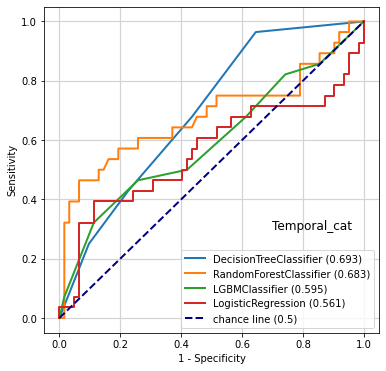

In [68]:
compute_matrics(joblib.load('predictions/predictions_temporal_cat.joblib'), 'Temporal_cat')

,Algo,Threshold
0,VotingClassifier,0.38034
1,StackingClassifier_logistic,0.37835
2,StackingClassifier_rf,0.23000
3,StackingClassifier_lgbm,0.51959


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.65556,0.47458,0.45161,0.50000,0.72581,0.59821
2,StackingClassifier_rf,0.51111,0.54167,0.38235,0.92857,0.32258,0.59850
0,VotingClassifier,0.62222,0.54054,0.43478,0.71429,0.58065,0.68721
1,StackingClassifier_logistic,0.80000,0.60870,0.77778,0.50000,0.93548,0.71832


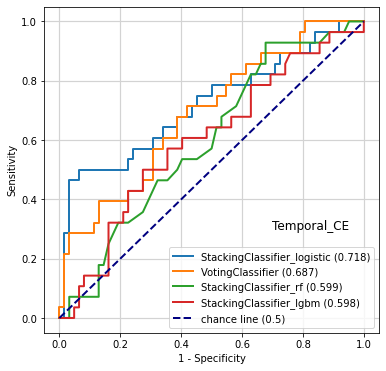

In [69]:
compute_matrics(joblib.load('predictions/preds_temporal_ensemble_cat.joblib'), 'Temporal_CE')

,Algo,Threshold
0,LogisticRegression,0.61462
1,DecisionTreeClassifier,0.72340
2,LGBMClassifier,0.34513
3,RandomForestClassifier,0.37750


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
2,LGBMClassifier,0.46667,0.52000,0.36111,0.92857,0.25806,0.55357
1,DecisionTreeClassifier,0.60000,0.51351,0.41304,0.67857,0.56452,0.66071
3,RandomForestClassifier,0.67778,0.53968,0.48571,0.60714,0.70968,0.68376
0,LogisticRegression,0.76667,0.68657,0.58974,0.82143,0.74194,0.82028


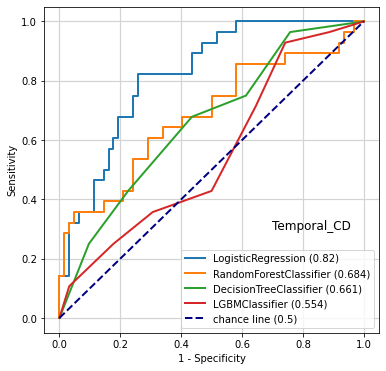

In [70]:
compute_matrics(joblib.load('predictions/predictions_temporal_cat_drug.joblib'), 'Temporal_CD')

,Algo,Threshold
0,VotingClassifier,0.52231
1,StackingClassifier_logistic,0.37443
2,StackingClassifier_rf,0.37000
3,StackingClassifier_lgbm,0.16765


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
2,StackingClassifier_rf,0.63333,0.56000,0.44681,0.75000,0.58065,0.66446
3,StackingClassifier_lgbm,0.57778,0.59574,0.42424,1.00000,0.38710,0.67396
0,VotingClassifier,0.73333,0.62500,0.55556,0.71429,0.74194,0.78975
1,StackingClassifier_logistic,0.78889,0.66667,0.65517,0.67857,0.83871,0.80703


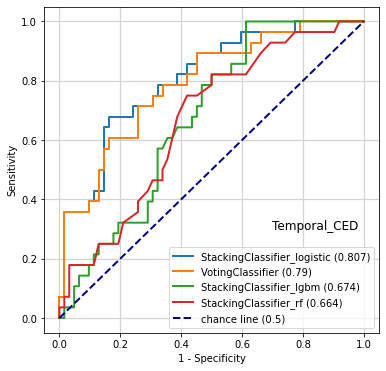

In [71]:
compute_matrics(joblib.load('predictions/preds_temporal_ensemble_cat_drug.joblib'), 'Temporal_CED')